# Import

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
from src.particle import *
from src.tracker import *
from src.widgets import *
import warnings
warnings.filterwarnings('ignore')

# Tracking

In [2]:
def track_values(p, charge=1., B=1.):
    return p/(charge*B)

In [3]:
# load in data

data = pd.read_hdf('EEEE/0_allcomb_0.h5')
coords = [f'{i}' for i in np.arange(0, 6624)]
hits = data[coords]
momenta = data.loc[:,['phi', 'pt']]
momenta.loc[:,'charge'] = data.loc[:,'pdg']/abs(data.loc[:,'pdg'])
momenta.loc[:,'phi'] = momenta.loc[:,'phi']*np.pi/180.
momenta.reset_index(inplace = True)
momenta

,index,phi,pt,charge
0,0,-0.272405,4.246419,-1.0
1,0,-2.578635,0.635968,-1.0
2,0,1.774206,0.368985,1.0
3,0,2.786167,3.223214,1.0


In [4]:
tw = TrackingWidget(momenta.loc[:1,:], B = 0.1)

Output()

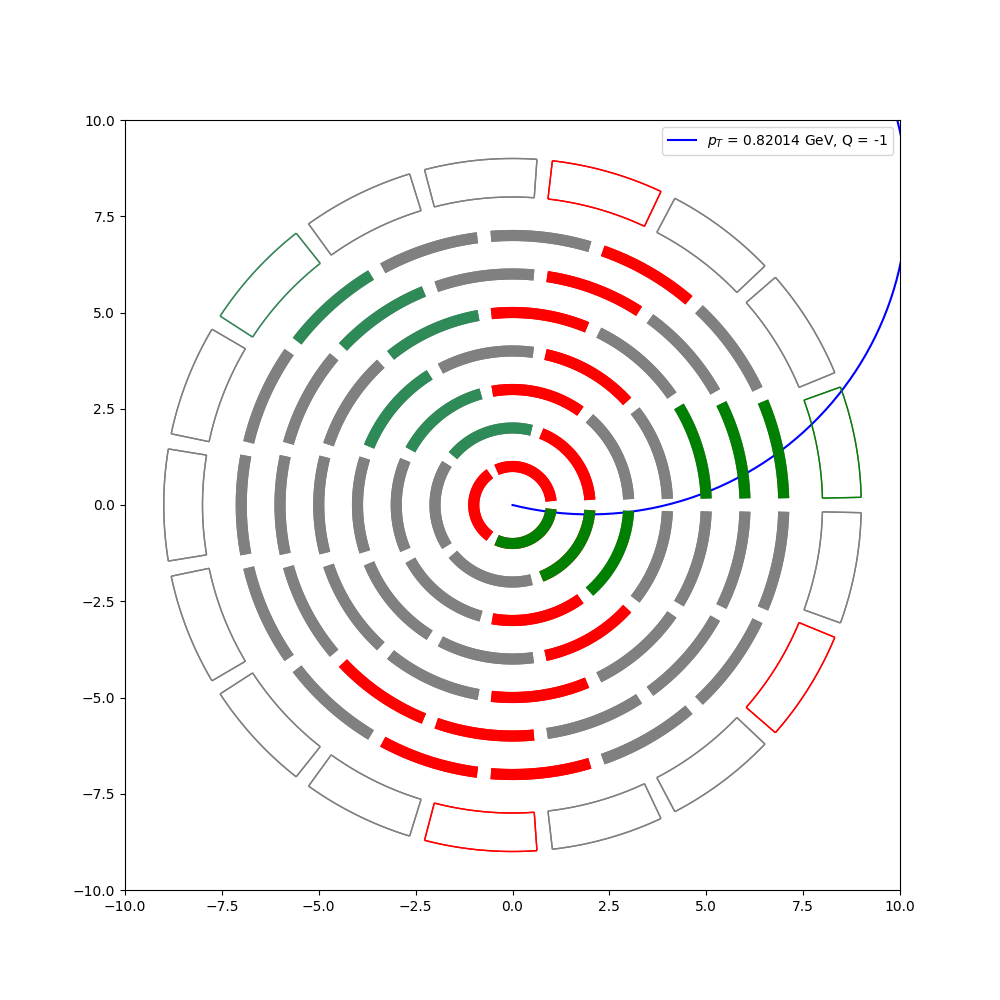

In [5]:
tw.show()

In [6]:
tw.particle.value

AttributeError: 'TrackingWidget' object has no attribute 'particle'

In [ ]:
tw.out = widgets.interactive_output(tw.update,{
    "radius": tw.r[i], 
    "phi": tw.phi[i], 
    "charge": tw.charge[i],
    "particle": tw.particle,
})

In [ ]:
from IPython.html import widgets
from IPython.display import display

geo={'USA':['CHI','NYC'],'Russia':['MOW','LED']}

def print_city(city):
    print city

def select_city(country):
    cityW.options = geo[country]


scW = widgets.Select(options=geo.keys())
init = scW.value
cityW = widgets.Select(options=geo[init])
j = widgets.interactive(print_city, city=cityW)
i = widgets.interactive(select_city, country=scW)
display(i)
display(j)

In [ ]:
from matplotlib.colors import to_rgba_array, to_rgba
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [ ]:
class ECal:
    def __init__(self, nrows, ncols, hits, max_hit, centercolor, crystal_edge = 1, noise = 0):
        column_names = ["x", "y", "edge", "content", "selected", "color", "center", "patch"]
        self.crystals_df = pd.DataFrame(columns = column_names)
        counter = 0
        for c in range(ncols):
            for r in range(nrows):
                color = "gray"
                content = "empty"
                center = False
                if hits[144*c+r] > 0.0:
                    content = "hit"
                    color = "red"
                if np.random.rand() < noise:
                    color = "red"
                    content = "noise"
                if int(144*c+r) in max_hit.keys():
                    center = True
                    color = centercolor[max_hit[int(144*c+r)]]
                x = r*crystal_edge
                y =  c*crystal_edge
                edge = crystal_edge-0.1
                patch = Rectangle((x, y), edge, edge, edgecolor = color, facecolor = color, linewidth = 0.5)
                self.crystals_df.loc[counter,column_names] = [x,y, edge, content, "not", color, center, patch]
                counter += 1
        self.set_colors()
        self.collection = PatchCollection(self.crystals_df.loc[:,"patch"], match_original=True)
        colors = to_rgba_array(self.crystals_df.loc[:,"color"].to_numpy())
        self.collection.set_edgecolors(colors)
        
    
    def set_colors(self):
        not_centers = self.crystals_df.loc[:,"center"] == False
        self.crystals_df.loc[not_centers, "color"] = "black"
        selected = (self.crystals_df.loc[:,"selected"] == "selected") & not_centers
        self.crystals_df.loc[selected, "color"] = "green"        
        selected = (self.crystals_df.loc[:,"selected"] == "hidden") & not_centers
        self.crystals_df.loc[selected, "color"] = "blue"
    
    def get_crystal(self, rectangle):
        x,y = rectangle.get_xy()
        for i,r in enumerate(self.crystals):
            for j,c in enumerate(r):
                if x == c.x and y==c.y:
                    return i,j

In [ ]:
import numpy as np
import pandas as pd

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path



from ipywidgets import Output
out = Output


class ECLWidget:

    def __init__(self, ecal):
        self.ecal = ecal    
        self.subplot_kw = dict(xlim=(-5,725), ylim=(-5,235), autoscale_on=False)
        
        fig, ax = plt.subplots(figsize=(5,2.5), subplot_kw=self.subplot_kw, dpi=400)
        ax.add_collection(self.ecal.collection)
        self.crystall_points = ax.scatter(ecal.crystals_df["x"], ecal.crystals_df["y"], s=0)
        self.xys = self.crystall_points.get_offsets()
        self.Npts = len(self.xys)
        self.canvas = ax.figure.canvas
        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []
        
    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.ecal.crystals_df.loc[self.ind, "selected"] = "selected"
        self.ecal.set_colors()
        colors = to_rgba_array(self.ecal.crystals_df.loc[:,"color"].to_numpy())
        self.ecal.collection.set_edgecolors(colors)
        self.canvas.draw_idle()
        
    def show(self):
        plt.show()
        
        

In [ ]:
data = pd.read_hdf('EEEE/0_allcomb_0.h5')
coords = [f'{i}' for i in np.arange(0, 6624)]
hits = data[coords]

max_hit = {}
for i in range(4):
    max_hit[int(hits.iloc[i].idxmax())] = i

In [ ]:
ecal = ECal(144,46,hits.sum().to_numpy(), max_hit, centercolor, crystal_edge=5)

In [ ]:
ew = ECLWidget( ecal)

In [ ]:
class ECLCrystal:
    def __init__(self, x, y, edge, hit=False, center=False, color="blue"):
        self.x = x
        self.y = y
        self.edge = edge
        self.hit = hit
        self.color = color
        self.center = center
        self.chosen = False
        self.facecolor = to_rgba("white")
        self.edgecolor = to_rgba("black")
        
    def draw(self,ax):
        ax.add_patch(Rectangle((self.x, self.y), self.edge, self.edge, edgecolor = self.edgecolor, facecolor = self.check_color(), linewidth = 0.5))
        
    def get_patch(self):
        return Rectangle((self.x, self.y), self.edge, self.edge, edgecolor = self.edgecolor, facecolor = self.check_color(), linewidth = 0.5)
    
    def check_color(self):
        if self.center:
            return self.color
        elif self.chosen:
            return "red"
        elif self.hit:
            return "red"
        else:
            return "grey"

In [ ]:
class ECal:
    def __init__(self, nrows, ncols, hits, max_hit, centercolor, crystal_edge = 1):
        self.crystals = np.empty((nrows, ncols), dtype = ECLCrystal)
        hit = False
        center = False
        color = 'blue'
        for c in range(ncols):
            for r in range(nrows):
                if hits[144*c+r] > 0.0:
                    hit = True
                if np.random.rand() < 0.0:
                    hit = True
                if int(144*c+r) in max_hit.keys():
                    center = True
                    color = centercolor[max_hit[int(144*c+r)]] 
                self.crystals[r,c] = ECLCrystal(r*crystal_edge, c*crystal_edge, crystal_edge-0.1, hit=hit, center=center, color=color)
                hit = False
                center = False
    
    def draw(self, ax):
        for r in self.crystals:
            for c in r:
                c.draw(ax)
    
    def draw_collection(self,ax):
        ax.add_collection(self.collection)
                
    def get_coords(self):
        coords = []
        for cols in self.crystals:
            for crystal in cols:
                coords.append([crystal.x, crystal.y])
        return coords
    
    def get_collection(self):
        crystals = []
        for c in self.crystals.flatten():
            crystals.append(c.get_patch())
        self.collection = PatchCollection(crystals, match_original=True)
        return self.collection
    
    def get_crystal(self, rectangle):
        x,y = rectangle.get_xy()
        for i,r in enumerate(self.crystals):
            for j,c in enumerate(r):
                if x == c.x and y==c.y:
                    return i,j

In [ ]:
class SelectFromCollection:

    def __init__(self, ax, ecal):
        self.canvas = ax.figure.canvas
        self.ecal = ecal    
        
        xy = np.array(ecal.get_coords()).T      
        self.ecal.get_collection()
        self.ecal.draw_collection(ax)
        self.collection = ax.scatter(xy[0], xy[1], s=0)
        self.xys = self.collection.get_offsets()
        self.Npts = len(self.xys)
    
        # Ensure that we have separate colors for each object
        self.fc = self.ecal.collection.get_edgecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))
        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:] = to_rgba("Black")
        self.fc[self.ind] = to_rgba("green")
        self.ecal.collection.set_edgecolors(self.fc)
        self.canvas.draw_idle()  

In [ ]:

plt.rc('font', size=5) 

centercolor = ['blue', 'cyan', 'gold', 'chartreuse']

ecal = ECal(144,46,hits.sum().to_numpy(), max_hit, centercolor, crystal_edge=5)
subplot_kw = dict(xlim=(-5,725), ylim=(-5,235), autoscale_on=False)
fig, ax = plt.subplots(figsize=(2,1), subplot_kw=subplot_kw, dpi=400)

selector = SelectFromCollection(ax, ecal)
#selector.onselect([[0,10],[10,10],[9,10],[0,1]])

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.show()